In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from tensorflow import keras
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K


In [3]:
print("Keras version:", keras.__version__)

Keras version: 2.12.0


# Data Exploration

In [4]:
DATA_PATH = '../InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')
SEED = 42

In [5]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df['image_filepath'].apply(lambda x: os.path.join(DATA_PATH, x))
df

,image_filepath,anomaly_class
0,../InfraredSolarModules\images/0.jpg,Offline-Module
1,../InfraredSolarModules\images/1.jpg,Offline-Module
2,../InfraredSolarModules\images/2.jpg,Offline-Module
3,../InfraredSolarModules\images/3.jpg,Offline-Module
4,../InfraredSolarModules\images/4.jpg,Offline-Module
...,...,...
19995,../InfraredSolarModules\images/19995.jpg,No-Anomaly
19996,../InfraredSolarModules\images/19996.jpg,No-Anomaly
19997,../InfraredSolarModules\images/19997.jpg,No-Anomaly
19998,../InfraredSolarModules\images/19998.jpg,No-Anomaly


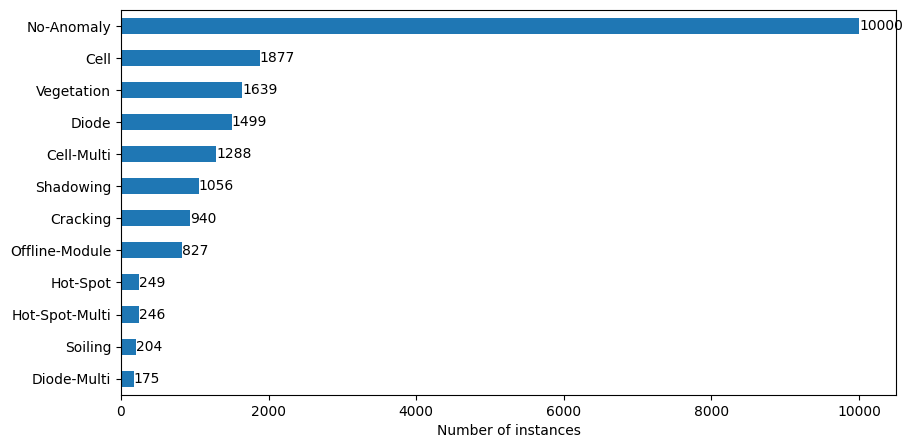

In [6]:
ax = df['anomaly_class'].value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

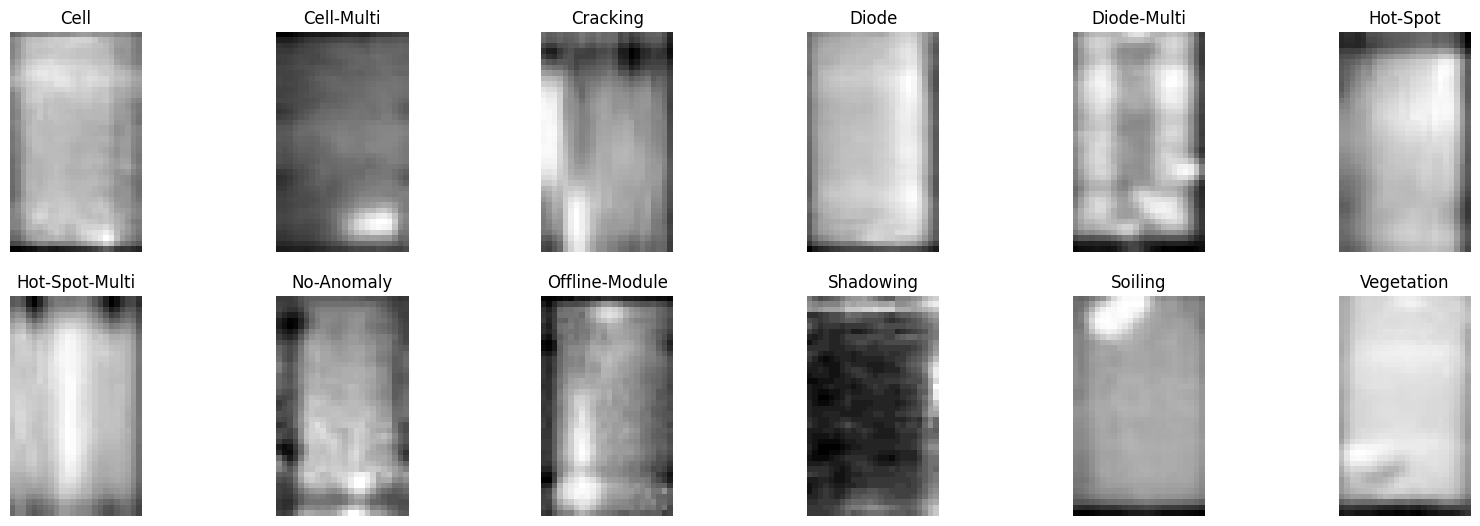

In [7]:
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(20,20))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
    with Image.open(image_path) as image:
        # Convert the image to a NumPy array
        image_array = np.array(image)
    plt.subplot(6, 6, i)
    plt.imshow(image_array, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.show()

# Pre-processing

In [8]:
# create binary dataset: No anomaly and anomaly
df_noanomaly = df[df['anomaly_class'] == 'No-Anomaly'].reset_index(drop=True)
df_anomaly = df[df['anomaly_class'] != 'No-Anomaly'].reset_index(drop=True)

In [9]:
# Randomly choose indices from no_anomaly class for test dataset
PICK = 0.005 # percentage
np.random.seed(SEED)
selected_indices = np.random.choice(len(df_noanomaly), size=int(len(df_noanomaly) * PICK), replace=False) # each element can be seleted only once

# Randomly choose samples from each class in anomaly dataframe for test dataset
PICK = 5 # sample
tmp = df_anomaly.groupby('anomaly_class').sample(PICK)

In [10]:
# Create X_test
X_test_df = df_noanomaly.loc[selected_indices].reset_index(drop=True)
X_test_df = pd.concat([X_test_df, tmp], ignore_index=True)

# Shuffle X_test
X_test_df = X_test_df.sample(frac=1,random_state=SEED).reset_index(drop=True)

# Create X_train
X_train_df = df_noanomaly.drop(index=selected_indices).reset_index(drop=True)

In [11]:
X_test_df

,image_filepath,anomaly_class
0,../InfraredSolarModules\images/10321.jpg,No-Anomaly
1,../InfraredSolarModules\images/1357.jpg,Diode
2,../InfraredSolarModules\images/7206.jpg,Cracking
3,../InfraredSolarModules\images/5882.jpg,Cell
4,../InfraredSolarModules\images/10039.jpg,No-Anomaly
...,...,...
100,../InfraredSolarModules\images/845.jpg,Diode-Multi
101,../InfraredSolarModules\images/13999.jpg,No-Anomaly
102,../InfraredSolarModules\images/3149.jpg,Shadowing
103,../InfraredSolarModules\images/5114.jpg,Cell


In [12]:
# Read image to numpy array
def build_dataset(df: pd.DataFrame):
    X = []
    y = []
    for i in range(len(df)):
        with Image.open(df.loc[i]['image_filepath']) as image:
            # Convert the image to a NumPy array
            image_array = np.array(image)
            image_array = np.expand_dims(image_array, axis=-1)
        X.append(image_array)
        if df.loc[i]['anomaly_class'] == 'No-Anomaly':
            y.append(0)
        else:
            y.append(1)
    X = np.array(X)
    y = np.array(y)
    return X,y

In [13]:
X_train, _ = build_dataset(X_train_df)
X_test, y_test = build_dataset(X_test_df)

In [14]:
X_train, X_val = train_test_split(X_train, test_size=0.2,random_state=42)

In [15]:
# Normalization
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# Autoencoder Class

In [16]:
class ConvAutoencoder:
	@staticmethod
	def build(height, width, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1
        
        # define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		
        # loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, kernel_size=(3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		
        # flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		
        # build the encoder model
		encoder = Model(inputs, latent, name="encoder")
		
        # start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		
        # loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, kernel_size=(3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			
        # apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, kernel_size=(3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [39]:
# construct convolutional autoencoder
EPOCHS = 1
INIT_LR = 1e-3
BS = 32
(encoder, decoder, autoencoder) = ConvAutoencoder.build(40, 24, 1)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

In [18]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 24, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                80656     
                                                                 
 decoder (Functional)        (None, 40, 24, 1)         121345    
                                                                 
Total params: 202,001
Trainable params: 201,617
Non-trainable params: 384
_________________________________________________________________


In [19]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 24, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 12, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 12, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 20, 12, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 6, 64)         18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 6, 64)         0         
                                                           

In [20]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 3840)              65280     
                                                                 
 reshape (Reshape)           (None, 10, 6, 64)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 12, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 20, 12, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 20, 12, 64)       256       
 hNormalization)                                           

In [38]:
X_train.shape

(7960, 40, 24, 1)

In [21]:
# train the convolutional autoencoder
H = autoencoder.fit(
	X_train, X_train,
	validation_data=(X_val, X_val),
	epochs=EPOCHS,
	batch_size=BS)

249/249 [==============================] - 18s 69ms/step - loss: 0.0051 - val_loss: 0.0183


In [22]:
def visualize_predictions(decoded, X_test, y_test, samples=2):
	idx = 1
	# loop over our number of output samples
	for i in range(0, samples):
		
		# grab the original image and reconstructed image
		original = X_test[i]
		recon = decoded[i]
		if y_test[i] == 0:
			title = 'No-Anomaly'
		else:
			title = 'Anomaly'
		
		plt.subplot(samples,2, idx)
		plt.imshow(original, cmap='gray')
		plt.title('Ori: ' + title)
		plt.axis('off')
		idx += 1

		plt.subplot(samples,2, idx)
		plt.imshow(recon, cmap='gray')
		plt.title('recon')
		plt.axis('off')
		idx += 1

		# plt.show()

4/4 [==============================] - 0s 15ms/step


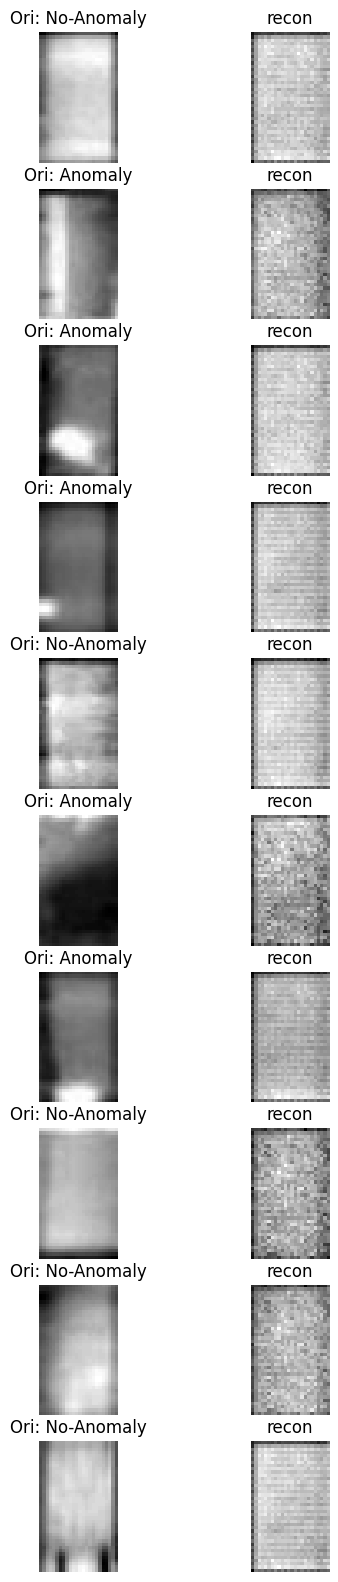

In [23]:
decoded = autoencoder.predict(X_test)
plt.figure(figsize=(5,20))
vis = visualize_predictions(decoded, X_test, y_test,10)

In [24]:
def plot_loss(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Model Loss', fontsize=20)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')   
    plt.legend()

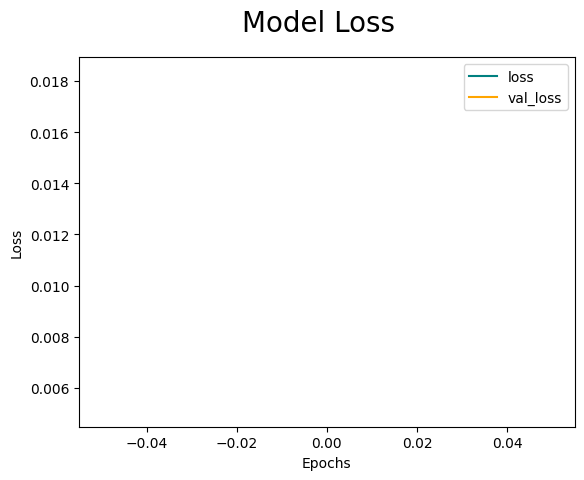

In [25]:
plot_loss(H)

In [26]:
QUANTILE = 0.4762 # 50 no-anomaly images out of 105 test images
errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(X_test, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
	
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, QUANTILE)
outlier_idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(outlier_idxs)))

[INFO] mse threshold: 0.012815744085792793
[INFO] 55 outliers found


In [27]:
y_pred = np.zeros(len(X_test))
y_pred[outlier_idxs] = 1

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56        50
           1       0.60      0.60      0.60        55

    accuracy                           0.58       105
   macro avg       0.58      0.58      0.58       105
weighted avg       0.58      0.58      0.58       105



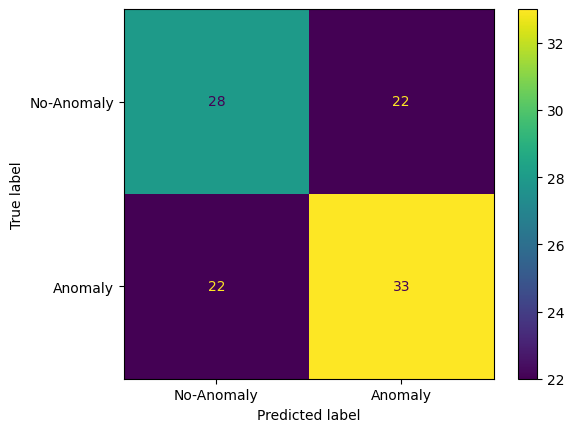

In [29]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=['No-Anomaly', 'Anomaly'])

In [30]:
autoencoder.save("../solar_anomaly_detection_app/models/model.h5")

# Anomaly classification

In [31]:
def classify_image(image_path, threshold=0.000877):
    # Preprocess the image for the model
    with Image.open(image_path) as im:
        # Convert the image to a NumPy array
        image = np.array(im)

    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    image = image / 255  # Normalize the pixel values

    # Make a prediction using the pre-trained model
    recon = autoencoder.predict(image)

    mse = np.mean((image - recon) ** 2)

    if mse > threshold:
        result = "Anomaly"
    else:
        result = "No-Anomaly"

    return result

In [32]:
# Perform image classification
prediction_result = classify_image(X_test_df['image_filepath'][0], threshold=thresh)
print(prediction_result)

prediction_result = classify_image(X_test_df['image_filepath'][1], threshold=thresh)
print(prediction_result)

1/1 [==============================] - 0s 29ms/step
No-Anomaly
1/1 [==============================] - 0s 24ms/step
Anomaly


In [33]:
tp_indices = [i for i in range(len(y_test)) if y_test[i] == 1 and y_pred[i] == 1]
tn_indices = [i for i in range(len(y_test)) if y_test[i] == 0 and y_pred[i] == 0]
fp_indices = [i for i in range(len(y_test)) if y_test[i] == 0 and y_pred[i] == 1]
fn_indices = [i for i in range(len(y_test)) if y_test[i] == 1 and y_pred[i] == 0]

print("TP indices:", tp_indices)
print("TN indices:", tn_indices)
print("FP indices:", fp_indices)
print("FN indices:", fn_indices)

TP indices: [1, 2, 5, 6, 12, 16, 20, 21, 23, 25, 30, 37, 42, 46, 50, 60, 62, 65, 66, 68, 71, 73, 75, 77, 78, 82, 83, 87, 96, 97, 99, 100, 102]
TN indices: [0, 4, 9, 15, 17, 19, 22, 26, 27, 36, 39, 40, 44, 45, 48, 49, 54, 55, 57, 59, 61, 69, 74, 80, 88, 91, 92, 98]
FP indices: [7, 8, 10, 11, 18, 24, 28, 29, 31, 34, 41, 43, 51, 53, 56, 58, 63, 76, 85, 86, 90, 101]
FN indices: [3, 13, 14, 32, 33, 35, 38, 47, 52, 64, 67, 70, 72, 79, 81, 84, 89, 93, 94, 95, 103, 104]


In [34]:
print(np.array(errors)[fp_indices])

[0.04480715 0.03038052 0.01707263 0.03758815 0.03695166 0.04142149
 0.03355767 0.02386718 0.01455848 0.01485983 0.01965368 0.01974556
 0.15596232 0.03516276 0.01552246 0.03518654 0.05275737 0.09773597
 0.01450341 0.03149113 0.01438019 0.04777825]


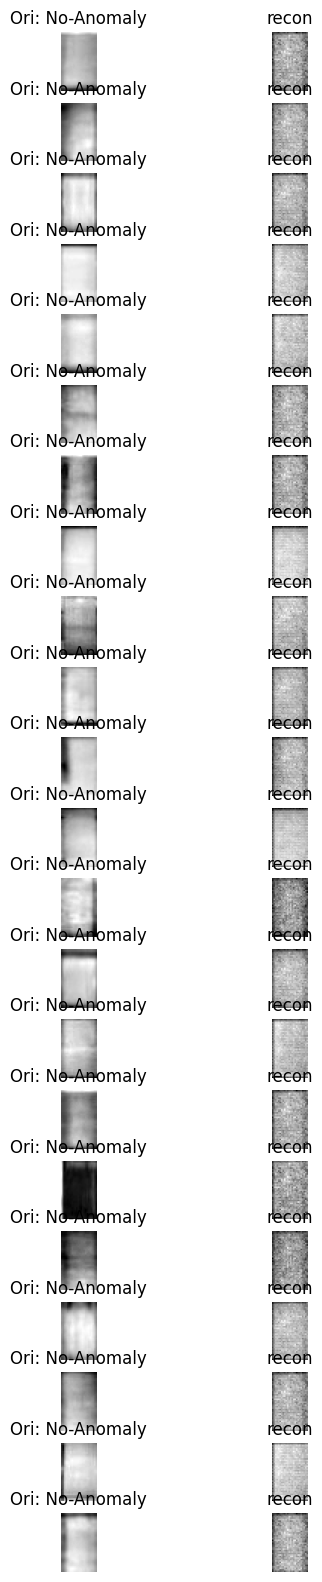

In [35]:
# Plot false positive
plt.figure(figsize=(5,20))
vis = visualize_predictions(decoded[fp_indices], X_test[fp_indices], y_test[fp_indices],len(fp_indices))

In [36]:
print(np.array(errors)[fn_indices])

[0.00467784 0.01046387 0.00371068 0.0119427  0.01163602 0.00780849
 0.00529952 0.00779533 0.00462334 0.01079626 0.01000598 0.00886089
 0.00899537 0.00529065 0.01027411 0.00972896 0.00861977 0.00636577
 0.01241098 0.01098703 0.00812805 0.01155672]


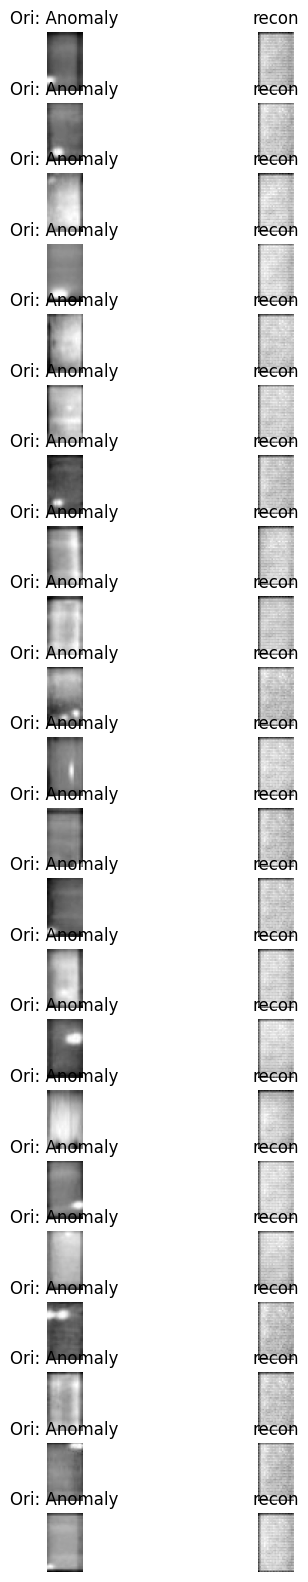

In [37]:
# Plot false negative
plt.figure(figsize=(5,20))
vis = visualize_predictions(decoded[fn_indices], X_test[fn_indices], y_test[fn_indices],len(fn_indices))